# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [111]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [112]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [113]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-11 09:00:00+09:00,51314.039062,51396.191406,51263.820312,51372.691406,0,0.0,0.0
2025-11-11 09:15:00+09:00,51374.769531,51432.261719,51255.101562,51432.261719,0,0.0,0.0
2025-11-11 09:30:00+09:00,51430.128906,51513.160156,51362.570312,51452.218750,0,0.0,0.0
2025-11-11 09:45:00+09:00,51447.980469,51471.269531,51313.550781,51367.968750,0,0.0,0.0
2025-11-11 10:00:00+09:00,51359.890625,51366.898438,51191.949219,51239.429688,0,0.0,0.0
2025-11-11 10:15:00+09:00,51232.230469,51309.960938,51206.769531,51292.808594,0,0.0,0.0
2025-11-11 10:30:00+09:00,51292.250000,51314.039062,51174.398438,51243.500000,0,0.0,0.0
2025-11-11 10:45:00+09:00,51241.691406,51245.050781,51148.031250,51159.910156,0,0.0,0.0
2025-11-11 11:00:00+09:00,51157.468750,51157.468750,51074.820312,51074.820312,0,0.0,0.0


## 前日終値の取得

In [114]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-04 00:00:00+09:00    51497.199219
2025-11-05 00:00:00+09:00    50212.269531
2025-11-06 00:00:00+09:00    50883.679688
2025-11-07 00:00:00+09:00    50276.371094
2025-11-10 00:00:00+09:00    50911.761719
2025-11-11 00:00:00+09:00    50700.320312
Name: Close, dtype: float64


Date
2025-11-10 00:00:00+09:00    50911.761719
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [115]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+402.28


## ローソク足チャート（小さいサイズ）

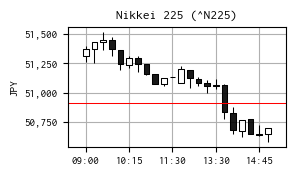

In [116]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [117]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [118]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-10 09:00:00+09:00,153.824005,153.843002,153.401001,153.798996,0,0.0,0.0
2025-11-10 09:15:00+09:00,153.807007,153.914001,153.740997,153.789001,0,0.0,0.0
2025-11-10 09:30:00+09:00,153.794998,153.869995,153.770996,153.804001,0,0.0,0.0
2025-11-10 09:45:00+09:00,153.798996,153.880005,153.733002,153.847000,0,0.0,0.0
2025-11-10 10:00:00+09:00,153.852997,153.953995,153.809006,153.843002,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-11 14:15:00+09:00,154.244995,154.251007,154.162003,154.188004,0,0.0,0.0
2025-11-11 14:30:00+09:00,154.184998,154.212997,154.156006,154.164001,0,0.0,0.0
2025-11-11 14:45:00+09:00,154.156006,154.164001,154.082001,154.123001,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [119]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-11 09:00:00+09:00,332.851434,333.384320,332.525687,333.231886
2025-11-11 09:15:00+09:00,333.184852,333.557710,332.408759,333.557710
2025-11-11 09:30:00+09:00,333.411968,333.950244,332.973998,333.555172
2025-11-11 09:45:00+09:00,333.406657,333.557581,332.535491,332.888144
2025-11-11 10:00:00+09:00,332.676247,332.721639,331.588431,331.895979
2025-11-11 10:15:00+09:00,331.774123,332.277497,331.609241,332.166420
2025-11-11 10:30:00+09:00,332.238115,332.379250,331.474748,331.922344
2025-11-11 10:45:00+09:00,332.046136,332.067904,331.439218,331.516193
2025-11-11 11:00:00+09:00,331.438074,331.438074,330.902613,330.902613


### 前日の終値のドル円レートから、前日の終値のドル換算

In [120]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-10 15:15:00+09:00


np.float64(153.95799255371094)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 330.6860584129047


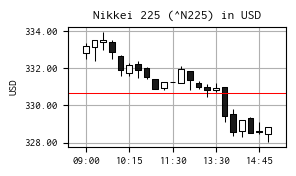

In [121]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()